In [1]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import glob
import re
import pandas as pd

In [2]:
files = glob.glob('hde-dimensions-vamp2/*.pkl')

In [8]:
hde_lag = []
hde_n_split = []
hde_n_dims = []
hde_labels = []
hde_train_scores = []
hde_test_scores = []
hde_iter = []

In [9]:
for file in files:
    match = re.match('hde-dimensions-vamp2/hde_scores_lag_([0-9]+)_k_([0-9]+)_components_([0-9]+)_hlag_([0-9]+)_iter_([0-9]+).pkl', file)
    if match:
        groups = match.groups()
        hde_lag.append(int(groups[3]))
        hde_n_split.append(int(groups[1]))
        hde_n_dims.append(int(groups[2]))
        hde_iter.append(int(groups[4]))
        
        train_scores, test_scores = pickle.load(open(file, 'rb'))
        hde_train_scores.append(train_scores)
        hde_test_scores.append(test_scores)
        hde_labels.append('SRV\n{} CVs'.format(hde_n_dims[-1]))

In [10]:
df = pd.DataFrame(columns=['dim', 'model', 'type', 'score'])

In [11]:
for dim, label, train, test in zip(hde_n_dims, hde_labels, hde_train_scores, hde_test_scores):
    train = np.array(train)
    test = np.array(test)
    idx = np.argsort(test)[::-1]
    train = train[idx[:10]]
    test = test[idx[:10]]
    for t in train:
        df.loc[len(df)] = {'dim': dim, 'model': label, 'type': 'train', 'score': t}
    for t in test:
        df.loc[len(df)] = {'dim': dim, 'model' : label, 'type' : 'test', 'score' : t}

In [12]:
df = df.sort_values('dim')

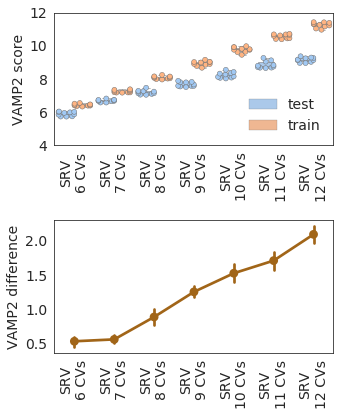

In [14]:
sns.set_style("white")
sns.set_palette('pastel')
plt.rcParams['font.size'] = 14

fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Top plot
ax = axes[0]

sns.boxplot(x="model", y="score", hue="type", data=df, ax=ax, whis=np.inf, linewidth=0.5)
sns.swarmplot(x="model", y="score", hue="type", data=df, dodge=True, linewidth=0.5, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('VAMP2 score')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim([4, 12])

handles, labels = ax.get_legend_handles_labels()
l = ax.legend(handles[0:2], labels[0:2], ncol=1, loc=4, frameon=False)

# Bottom plot
ax = axes[1]
sns.set_palette('BrBG')

df_diff = df[df['type'] == 'train'].copy()
df_diff['score'] = df_diff['score'].values - df[df['type'] == 'test']['score'].values

sns.pointplot(x='model', y='score', data=df_diff)
ax.set_xticklabels(df['model'].unique(), rotation=90)
ax.set_ylabel('VAMP2 difference')
ax.set_xlabel('')

plt.tight_layout()
plt.savefig('figures/hde_dim_vamp2.pdf', dpi=300)
plt.show()